In [3]:
from tqdm import tqdm
import sys
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# features

In [3]:
trains = pd.concat(
    [
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/2_routes_excluded/SEV_MAD_trains.pkl",
        ),
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/2_routes_excluded/MAD_SEV_trains.pkl",
        ),
    ]
).reset_index(drop=True)

In [4]:
data = (
    trains.groupby(["train_id", "days_till_dep"])
    .agg(
        mean_econ_price=("Turista_Promo +_price", np.nanmean),
        mean_first_price=("Preferente_Promo +_price", np.nanmean),
        max_econ_seats=("Turista_Promo +_seats", max),
        min_econ_seats=("Turista_Promo +_seats", min),
        mean_econ_seats=("Turista_Promo +_seats", "mean"),
        max_first_seats=("Preferente_Promo +_seats", max),
        min_first_seats=("Preferente_Promo +_seats", min),
        mean_first_seats=("Preferente_Promo +_seats", "mean"),
        departure=("departure", "first"),
        duration=("duration", "first"),
    )
    .reset_index()
)

In [5]:
data["econ_seats_sold"] = (data["max_econ_seats"] - data["min_econ_seats"]).round()
data["first_seats_sold"] = (data["max_first_seats"] - data["min_first_seats"]).round()

In [6]:
data["weekday"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday()
)
data["depart_month"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month
)
data["depart_hour"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour
)
# only jan, feb, march
data = data.loc[data["depart_month"] < 4].reset_index(drop=True)

In [7]:
data["day_part"] = data["depart_hour"] > 12
data["const"] = 1

In [8]:
#filter for seats sold on an individual day is less than 100
data = data.loc[data["econ_seats_sold"] < 100].reset_index(drop=True)

In [9]:
# filter for those trains, that data is available for more than 15 days
id_obs = data.groupby("train_id")["days_till_dep"].count().reset_index()
train_ids = list(id_obs.loc[id_obs["days_till_dep"] > 15]["train_id"].values)

data = data.loc[data["train_id"].isin(train_ids)].reset_index(drop=True)

In [10]:
# filter for trains, whos data is close to departure day by min(days until departure) < 3)

min_days_until_dep = data.groupby("train_id")["days_till_dep"].min().reset_index()
data = data.loc[
    data["train_id"].isin(
        list(
            min_days_until_dep.loc[min_days_until_dep["days_till_dep"] < 3]["train_id"]
        )
    )
]

In [11]:
data["price_change"] = (
    data.sort_values(by=["train_id", "days_till_dep"], ascending=False)
    .groupby("train_id")["mean_econ_price"]
    .transform("diff")
)

data["price_change_percentage"] = (data["price_change"] / data["mean_econ_price"]).round(3)

data["price_change_direction"] = np.where(
    data["price_change_percentage"] > 0,
    1,
    np.where(data["price_change_percentage"] < 0, -1, 0),
)

In [12]:
# filter if price drop is greater than 0.9
data = data.loc[data["price_change_percentage"]>-0.9].reset_index(drop=True)

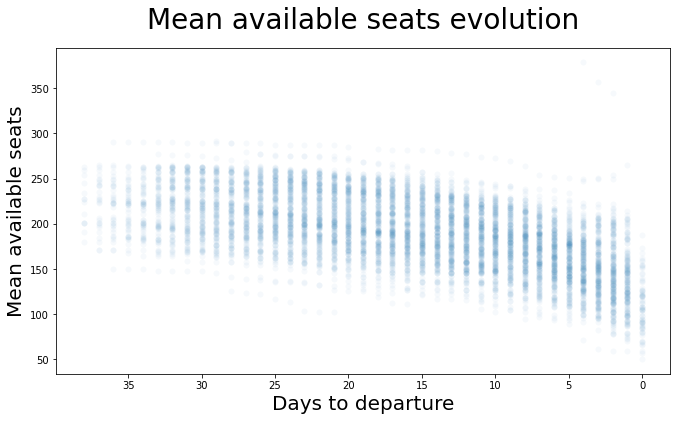

In [13]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="mean_econ_seats",
    estimator="mean",
    alpha=0.04
)

plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

In [ ]:
# differentiate big and small trains, work with small
max_seats = data.groupby("train_id")["mean_econ_seats"].max().reset_index()


data_small =data.loc[
    data["train_id"].isin(
        list(max_seats.loc[max_seats["mean_econ_seats"] < 330]["train_id"])
    )
]

data_big =data.loc[
    data["train_id"].isin(
        list(max_seats.loc[max_seats["mean_econ_seats"] > 350]["train_id"])
    )
]

In [ ]:
data = data_small

In [14]:
len(data["train_id"].unique())

227

In [15]:
price_changed = data.groupby("train_id")["price_change"].sum().reset_index().round(2)
price_changed["price_change"].value_counts()

13.10    44
19.25    39
6.90     31
0.00     24
25.45    14
12.35     9
6.20      8
18.55     6
15.80     4
6.15      3
14.65     2
2.66      2
15.89     2
21.41     2
20.85     2
23.15     2
31.60     2
6.91      1
12.07     1
6.92      1
20.27     1
12.24     1
15.47     1
9.27      1
25.46     1
25.44     1
9.28      1
7.27      1
7.19      1
18.74     1
21.63     1
16.95     1
15.42     1
28.76     1
15.45     1
15.66     1
27.20     1
11.95     1
7.93      1
11.22     1
11.38     1
9.33      1
15.01     1
19.26     1
16.49     1
10.59     1
15.11     1
17.52     1
Name: price_change, dtype: int64

In [16]:
data["price_change_direction"] = np.where(
    data["price_change_percentage"] > 0,
    1,
    np.where(data["price_change_percentage"] < 0, -1, 0),
)
data["price_increase"] = np.where(data["price_change_percentage"] > 0, 1, 0)

In [17]:
data["seats_sold_prev_day"] = data.sort_values(by=["train_id", "days_till_dep"])[
    "econ_seats_sold"
].shift(-2)

data["sales_prev_day"] = data["seats_sold_prev_day"] > 0

In [18]:
data["max_seat_capacity"] = 313

data["capacity"] = data["mean_econ_seats"]/data["max_seat_capacity"]

data["loading_factor"] = (
    (data["max_seat_capacity"] - data["mean_econ_seats"]) / data["max_seat_capacity"]
).round(2)

###ezeket benne van hogy ki kell baszni
drop_trains = data.loc[(data["days_till_dep"] < 5) & (data["capacity"] > 0.75),"train_id"].unique()

data = data.loc[~data["train_id"].isin(drop_trains)].reset_index(drop=True)
###


data["loading_factor_round"] = (
    (data["max_seat_capacity"] - data["mean_econ_seats"]) / data["max_seat_capacity"]
).round(1)

data["loading_factor_cat"] = np.where(
    data["loading_factor"] > data["loading_factor"].median(), "high", "low"
)

In [19]:
data.to_pickle("/Users/vigadam/Documents/github/renfe-analysis/data/MAD_SEV_small_trains_features.pkl")

___

In [70]:
data = pd.concat(
    [
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/3_features/MAD_BAR_small_trains_features.pkl"
        ),
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/3_features/MAD_COR_small_trains_features.pkl"
        ),
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/3_features/MAD_ZAR_small_trains_features.pkl"
        ),
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/3_features/MAD_SEV_small_trains_features.pkl"
        ),
    ]
).reset_index(drop=True)

In [71]:
data["route"] = [data.loc[i, "train_id"][:-38] for i in range(data.shape[0])]

In [72]:
data["route"] = data["route"].astype("category")

In [73]:
data.to_pickle("data/data_work.pkl")

## Figures

In [108]:
data = pd.read_pickle("data/data_work.pkl")

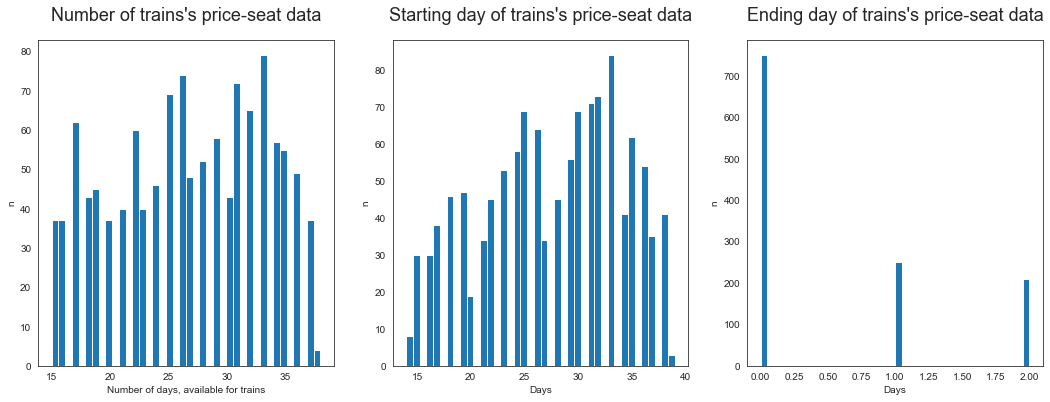

In [42]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "days_till_dep"
]

plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 3, 1)
#ax1.set_xlim(13, 35)
# ax1.set_ylim(0,50)
ax1.hist(figdata.count(), bins=40)
plt.xlabel("Number of days, available for trains", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title("Number of trains's price-seat data", fontsize=18, y=1.04)


ax2 = plt.subplot(1, 3, 2)
# ax2.set_xlim(35, 110)
# ax2.set_ylim(0, 0.14)
ax2.hist(figdata.last(), bins=40)
plt.xlabel("Days", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title(
    "Starting day of trains's price-seat data", fontsize=18, y=1.04
)


ax3 = plt.subplot(1, 3, 3)
# ax3.set_xlim(35, 110)
# ax3.set_ylim(0, 0.14)
ax3.hist(figdata.first(), bins=40)
plt.xlabel("Days", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title(
    "Ending day of trains's price-seat data", fontsize=18, y=1.04
)

plt.savefig("figures/days_plots", dpi=300)

plt.show()

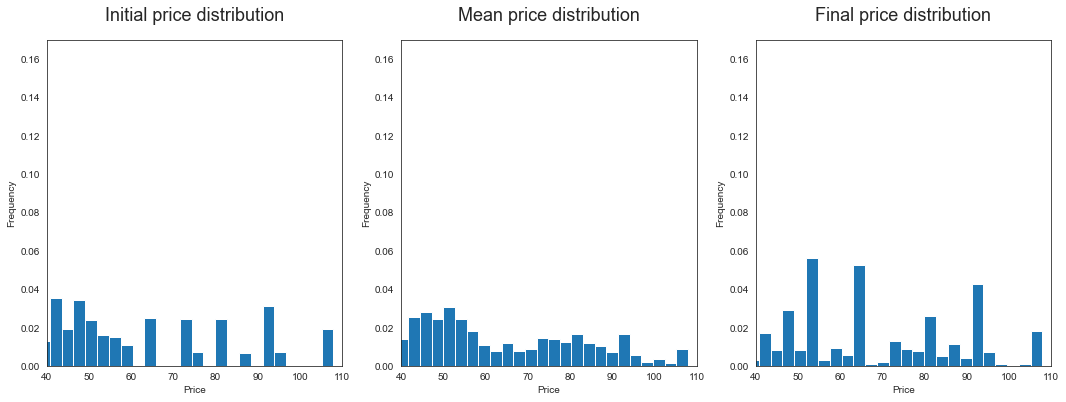

In [46]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "mean_econ_price"
]

plt.figure(figsize=(18, 6))

xlim_min = 40
xlim_max = 110
ylim_min = 0
ylim_max = 0.17

ax1 = plt.subplot(1, 3, 1)
ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(ylim_min, ylim_max)
ax1.hist(figdata.last(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Initial price distribution", fontsize=18, y=1.04)


ax2 = plt.subplot(1, 3, 2)
ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(ylim_min, ylim_max)
ax2.hist(figdata.mean(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Mean price distribution", fontsize=18, y=1.04)


ax3 = plt.subplot(1, 3, 3)
ax3.set_xlim(xlim_min, xlim_max)
ax3.set_ylim(ylim_min, ylim_max)
ax3.hist(figdata.first(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Final price distribution", fontsize=18, y=1.04)

plt.savefig("figures/price_distributions", dpi=300)

plt.show()

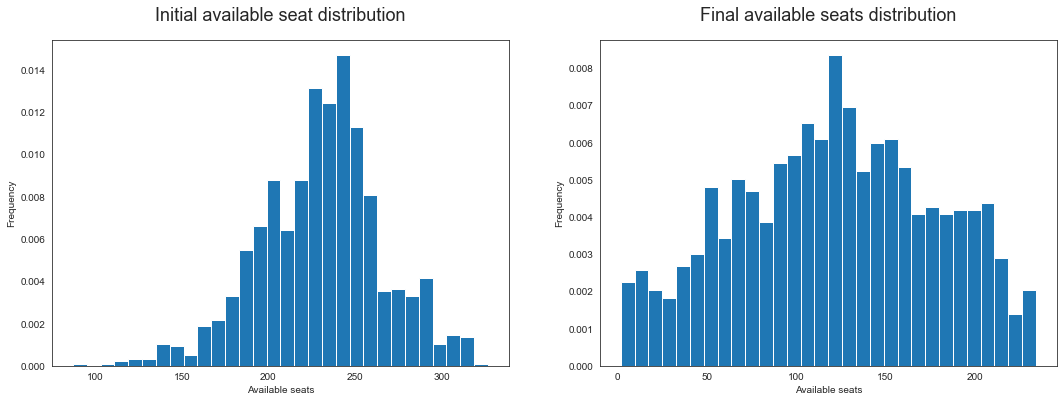

In [47]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "mean_econ_seats"
]

plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 2, 1)
#ax1.set_xlim(35, 110)
#ax1.set_ylim(0, 0.14)
ax1.hist(figdata.last(), bins=30, density=True)
plt.xlabel("Available seats", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Initial available seat distribution", fontsize=18, y=1.04)


ax3 = plt.subplot(1, 2, 2)
#ax3.set_xlim(35, 110)
#ax3.set_ylim(0, 0.14)
ax3.hist(figdata.first(), bins=30, density=True)
plt.xlabel("Available seats", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Final available seats distribution", fontsize=18, y=1.04)

plt.savefig("figures/price_distributions", dpi=300)

plt.show()

In [1]:
# features included 2020.12.12

In [4]:
data = pd.read_pickle("data/data_work.pkl")

data = data.drop(columns=["ln_price","ln_econ_seat","const","loading_factor_round","loading_factor_cat"])

data['peak_hour'] = np.where(data["depart_hour"].isin([7,8,9]),1,0)

data = data.loc[data["days_till_dep"]<=30]

data["days_since"] = abs(data["days_till_dep"] - 30)

data = data.merge(
    data.groupby(["route", "days_till_dep"])["loading_factor"]
    .median()
    .reset_index()
    .rename(columns={"loading_factor": "loading_factor_median"}),
    on=["route", "days_till_dep"],
    how="left",
)

data["loading_factor_cat"] = np.where(
    data["loading_factor"] > data["loading_factor_median"], "high", "low"
)

In [5]:
data.to_pickle("data/data_work.pkl")

___